In [1]:
import time
import datetime
import random
import gc

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

from transformers import BertTokenizer, DistilBertTokenizer
from transformers import AutoConfig
from transformers import AutoModelForSequenceClassification
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup

import torch

## Helper functions

In [2]:
def updating_interval(total_iterations, number_of_desired_updates):
    '''
    This function will try to pick an intelligent progress update interval 
    based on the magnitude of the total iterations.

    Parameters:
      `total_iters` - The number of iterations in the for-loop.
      `num_desired_updates` - How many times we want to see an update over the 
                              course of the for-loop.
    '''
    
    # Divide the total iterations by the desired number of updates.
    exact_interval = total_iterations / number_of_desired_updates

    # The `round` function has the ability to round down a number to, e.g., the
    # nearest thousandth: round(exact_interval, -3)
    #
    # To determine the magnitude to round to, find the magnitude of the total,
    # and then go one magnitude below that.

    # Get the order of magnitude of the total.
    order_of_magntiude = len(str(total_iterations)) - 1

    # Our update interval should be rounded to an order of magnitude smaller. 
    round_magnitude = order_of_magntiude - 1

    # Round down and cast to an int.
    update_interval = int(round(exact_interval, -round_magnitude))

    # Don't allow the interval to be zero!
    if update_interval == 0:
        update_interval = 1

    return update_interval

In [3]:
def show_time(elapsed_time):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_time_rounded = int(round((elapsed_time)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_time_rounded))

In [12]:
def extract_data(data):
    '''
    Extract text and labels in a list
    '''
    
    text = []
    labels=[]
    
    # Iterate over the data
    for idx, row in data.iterrows():
        # The text is a `bytes` object, decode to string.
        text.append(row['clean_text'])

        # Cast the label from `np.int64` to `int`
        labels.append(int(row['labels']))
        
    return text, labels

## Import data

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
train_data = pd.read_csv('/content/drive/MyDrive/NNDL_Datasets/IMDB_train.csv')
test_data = pd.read_csv('/content/drive/MyDrive/NNDL_Datasets/IMDB_test.csv')
val_data = pd.read_csv('/content/drive/MyDrive/NNDL_Datasets/IMDB_val.csv')

In [7]:
# For YELP data
#train_data = pd.read_csv('/content/drive/MyDrive/NNDL_Datasets/YELP_train.csv')
#test_data = pd.read_csv('/content/drive/MyDrive/NNDL_Datasets/YELP_test.csv')
#val_data = pd.read_csv('/content/drive/MyDrive/NNDL_Datasets/YELP_val.csv')
#train_data['labels'] = train_data['labels']-1
#test_data['labels'] = test_data['labels']-1
#val_data['labels'] = val_data['labels']-1

## Extract data and see the shape and labels

In [11]:
train_text, train_labels = extract_data(train_data)
test_text, test_labels = extract_data(test_data)
val_text, val_labels = extract_data(val_data)

# Print some stats.
print('{:,} Training Samples'.format(len(train_labels)))
print('{:,} Test Samples'.format(len(test_labels)))
print('{:,} Validation Samples'.format(len(val_labels)))
print('Labels:', np.unique(train_labels))

35,000 Training Samples
7,500 Test Samples
7,500 Validation Samples
Labels: [0 1]


## See few examples of review and label

In [13]:
for i,j in zip(train_text[:3], train_labels[:3]):
    print('Review:', i)
    print('Label:', j)
    print('-----------------')

Review: john garfield plays marine blinded grenade fighting guadalcanal learn live disability stereotypical notions blindness sure hell burden everyone hospital staff fellow wounded marines cant get neither girl back home played eleanor parker hes stubborn blinded fears self pity prejudices complex role garfield carries memorably great performance keeps one watching spite ever present syrupy melodrama best scenes guadalcanal hes machine gun nest trying fend advancing japanese soldiers hellish looking night time battle later dream sequence hospital sees walking train platform white cane dark glasses holding tin cup girlfriend walks backward away camera
Label: 1
-----------------
Review: saw anatomy years ago dubbed friends house dont remember much saw video store second one really related first one franka ponte makes little cameo one okay good first one im seeing first one tonight dubbed collectors edition really like german movies like one interesting people cults like one movie could 

## Check class distrubution

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


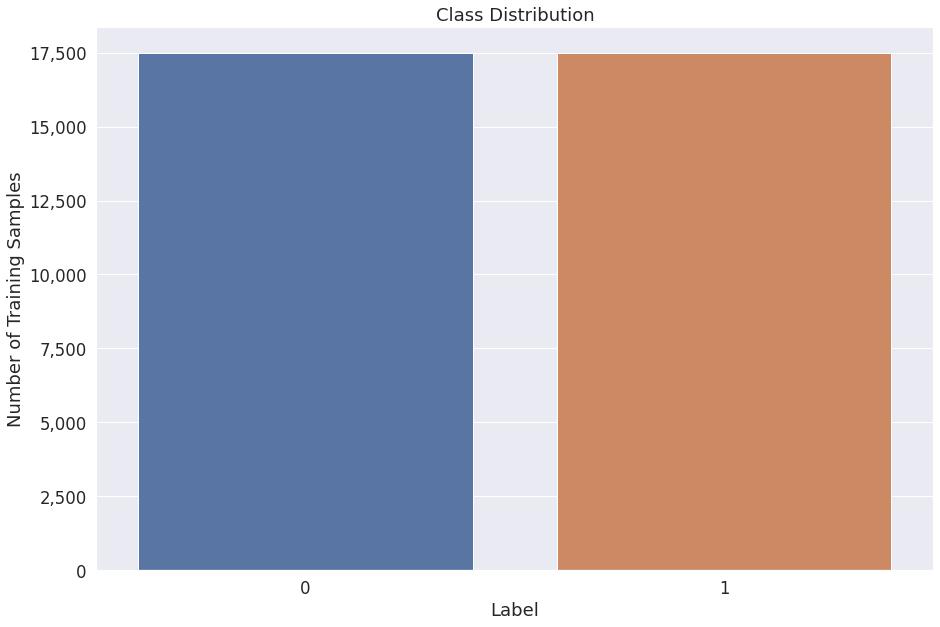

In [14]:
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (15,10)

# Plot the number of tokens of each length.
ax = sns.countplot(train_labels)

# Add labels
plt.title('Class Distribution')
plt.xlabel('Label')
plt.ylabel('Number of Training Samples')

# Add thousands separators to the y-axis labels.
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

plt.show()

# Smart Batching

## Load tokenizer

In [15]:
# Load the tokenizer.
print('Loading tokenizer...')

Loading tokenizer...


In [16]:
# For BERT model
#tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [17]:
# For DistilBERT model
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', do_lower_case=True)

## Tokenization without padding

In [18]:
full_input_ids = []
labels = []
max_len= 400

# Tokenize all training samples
print('Tokenizing {:,} training samples'.format(len(train_text)))

# Choose an interval on which to print progress updates.
update_interval = updating_interval(total_iterations=len(train_text), number_of_desired_updates=10)

# Report progress for each training sample
for text in train_text:
    if ((len(full_input_ids) % update_interval) == 0):
        print('--- Tokenized {:,} samples.'.format(len(full_input_ids)))

    # Tokenize the text.
    input_ids = tokenizer.encode(text=text,               # Review text
                                 add_special_tokens=True, # Add special tokens. 
                                 max_length=max_len,      # Do truncate to `max_len`
                                 truncation=True,         # Do truncate
                                 padding=False)           # No padding
                                 
    # Add the tokenized result to our list.
    full_input_ids.append(input_ids)
    
print('DONE.')

Tokenizing 35,000 training samples
--- Tokenized 0 samples.
--- Tokenized 4,000 samples.
--- Tokenized 8,000 samples.
--- Tokenized 12,000 samples.
--- Tokenized 16,000 samples.
--- Tokenized 20,000 samples.
--- Tokenized 24,000 samples.
--- Tokenized 28,000 samples.
--- Tokenized 32,000 samples.
DONE.


## Sorting by length

In [19]:
# Get all of the lengths.
not_sorted_lengths = [len(values) for values in full_input_ids]

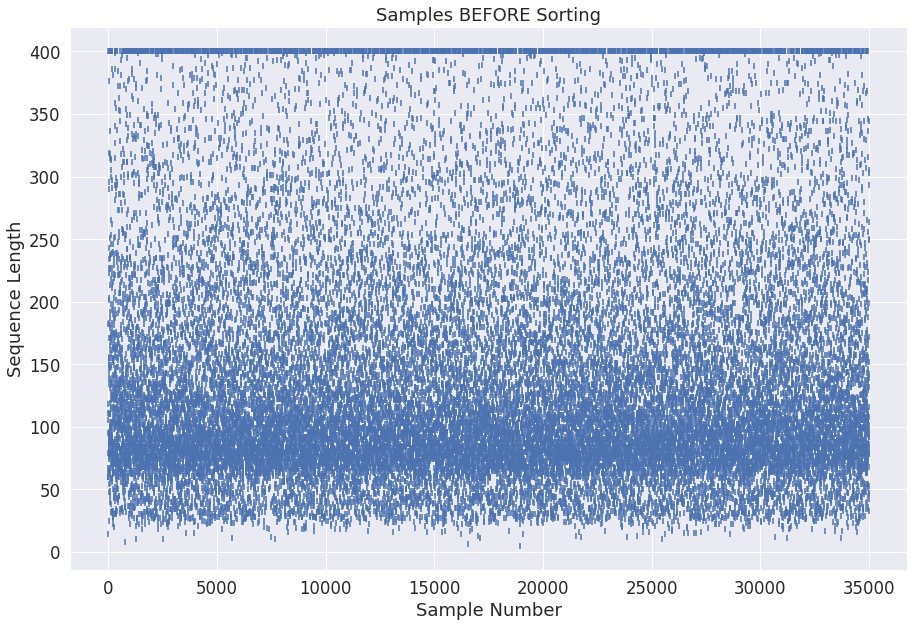

In [20]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (15,10)

plt.scatter(range(0, len(not_sorted_lengths)), 
            not_sorted_lengths, marker="|")

plt.xlabel('Sample Number')
plt.ylabel('Sequence Length')
plt.title('Samples BEFORE Sorting')

plt.show()

In [21]:
# Sort the two lists together by the length of the input sequence.
train_samples = sorted(zip(full_input_ids, train_labels), key=lambda x: len(x[0]))

print('Shortest sample:', len(train_samples[0][0]))
print('Longest sample:', len(train_samples[-1][0]))

Shortest sample: 5
Longest sample: 400


In [22]:
# Get the new list of lengths after sorting.
sorted_lengths = [len(values[0]) for values in train_samples]

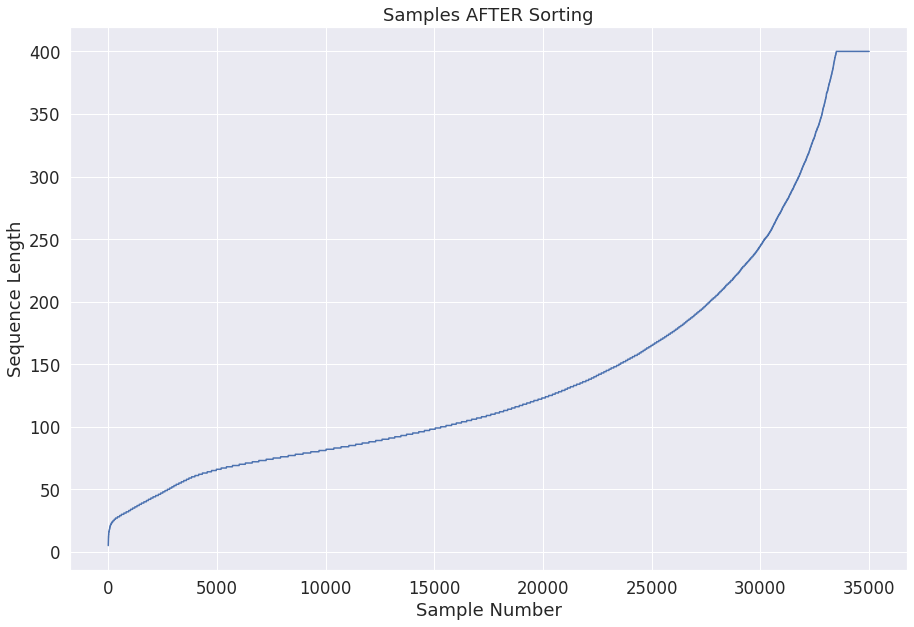

In [23]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (15,10)

plt.plot(range(0, len(sorted_lengths)), 
         sorted_lengths)

plt.xlabel('Sample Number')
plt.ylabel('Sequence Length')
plt.title('Samples AFTER Sorting')

plt.show()

## Random batch selection

In [24]:
batch_size = 16

# List of batches
batches_of_ordered_sentences = []
batches_of_ordered_labels = []

print('Creating training batches of size {:}'.format(batch_size))

# Loop over all of the samples   
while len(train_samples) > 0:

    if ((len(batches_of_ordered_sentences) % 500) == 0):
        print('--- Selected {:,} batches.'.format(len(batches_of_ordered_sentences)))

    # `to_take` is our actual batch size. It will be `batch_size` until we get to the last batch, which may be smaller. 
    to_take = min(batch_size, len(train_samples))

    # Pick a random index in the list of remaining samples to start our batch at.
    select = random.randint(0, len(train_samples) - to_take)

    # Select a contiguous batch of samples starting at `select`.
    batch = train_samples[select:(select + to_take)]

    # Each sample is a tuple--split them apart to create a separate list of sequences and a list of labels for this batch.
    batches_of_ordered_sentences.append([value[0] for value in batch])
    batches_of_ordered_labels.append([value[1] for value in batch])

    # Remove these samples from the list.
    del train_samples[select:select + to_take]

print('\nDONE.')

Creating training batches of size 16
--- Selected 0 batches.
--- Selected 500 batches.
--- Selected 1,000 batches.
--- Selected 1,500 batches.
--- Selected 2,000 batches.

DONE.


## Add padding

In [25]:
py_inputs = []
py_attn_masks = []
py_labels = []

# For each batch
for (batch_inputs, batch_labels) in zip(batches_of_ordered_sentences, batches_of_ordered_labels):

    # New version of the batch, this time with padded sequences and now with attention masks defined.
    batch_of_padded_inputs = []
    batch_of_attn_masks = []
    
    # First, find the longest sample in the batch. Note that the sequences do currently include the special tokens!
    max_size = max([len(sen) for sen in batch_inputs])

    # For each input in this batch
    for sen in batch_inputs:
        
        # The number of pad tokens we need to add
        num_pads = max_size - len(sen)

        # Add `num_pads` padding tokens to the end of the sequence.
        padded_input = sen + [tokenizer.pad_token_id]*num_pads

        # Define the attention mask--it's just a `1` for every real token and a `0` for every padding token.
        attn_mask = [1] * len(sen) + [0] * num_pads

        # Add the padded results to the batch.
        batch_of_padded_inputs.append(padded_input)
        batch_of_attn_masks.append(attn_mask)

    # Our batch has been padded, so we need to save this updated batch. 
    # We also need the inputs to be PyTorch tensors, so we'll do that here.
    py_inputs.append(torch.tensor(batch_of_padded_inputs))
    py_attn_masks.append(torch.tensor(batch_of_attn_masks))
    py_labels.append(torch.tensor(batch_labels))


## Function to wrap the whole novel approach

In [26]:
def make_smart_batches(text_samples, labels, batch_size):
    '''
    This function combines all of the required steps to prepare batches.
    '''

    print('Creating Smart Batches from {:,} examples with batch size {:,}\n'.format(len(text_samples), batch_size))

    # =========================
    #   Tokenize & Truncate

    full_input_ids = []

    # Tokenize all  examples
    print('Tokenizing {:,} samples'.format(len(labels)))

    # Choose an interval on which to print progress updates.
    update_interval = updating_interval(total_iterations=len(labels), number_of_desired_updates=10)

    # For each example
    for text in text_samples:
        
        if ((len(full_input_ids) % update_interval) == 0):
            print('  Tokenized {:,} samples.'.format(len(full_input_ids)))

        # Tokenize the sample.
        input_ids = tokenizer.encode(text=text,              # Text to encode.
                                    add_special_tokens=True, # Add specials.
                                    max_length=max_len,      # Do Truncate
                                    truncation=True,         # Do Truncate
                                    padding=False)           # No padding.
                                    
        # Add the tokenized result to our list.
        full_input_ids.append(input_ids)
        
    print('DONE.')
    print('{:>10,} samples\n'.format(len(full_input_ids)))

    # =========================
    #      Select Batches 

    # Sort the two lists together by the length of the input sequence.
    samples = sorted(zip(full_input_ids, labels), key=lambda x: len(x[0]))

    print('{:>10,} samples AFTER sorting\n'.format(len(samples)))


    # List of batches that we'll construct.
    batches_of_ordered_sentences = []
    batches_of_ordered_labels = []

    print('Creating batches of size {:}'.format(batch_size))

    # Choose an interval on which to print progress updates.
    update_interval = updating_interval(total_iterations=len(samples), number_of_desired_updates=10)
    
    # Loop over all of the samples    
    while len(samples) > 0:
        
        if ((len(batches_of_ordered_sentences) % update_interval) == 0 \
            and not len(batches_of_ordered_sentences) == 0):
            print('  Selected {:,} batches.'.format(len(batches_of_ordered_sentences)))

        # `to_take` is our actual batch size. It will be `batch_size` until we get to the last batch, which may be smaller. 
        to_take = min(batch_size, len(samples))

        # Pick a random index in the list of remaining samples to start our batch at.
        select = random.randint(0, len(samples) - to_take)

        # Select a contiguous batch of samples starting at `select`.
        batch = samples[select:(select + to_take)]


        # Each sample is a tuple--split them apart to create a separate list of sequences and a list of labels for this batch.
        batches_of_ordered_sentences.append([value[0] for value in batch])
        batches_of_ordered_labels.append([value[1] for value in batch])

        # Remove these samples from the list.
        del samples[select:select + to_take]

    print('DONE.')

    # =========================
    #        Add Padding  

    print('Padding out sequences within each batch')

    py_inputs = []
    py_attn_masks = []
    py_labels = []

    # For each batch
    for (batch_inputs, batch_labels) in zip(batches_of_ordered_sentences, batches_of_ordered_labels):

        # New version of the batch, this time with padded sequences and now with attention masks defined.
        batch_of_padded_inputs = []
        batch_of_attn_masks = []
        
        # First, find the longest sample in the batch. Note that the sequences do currently include the special tokens!
        max_size = max([len(sen) for sen in batch_inputs])

        # For each input in this batch
        for sen in batch_inputs:
            
            # The pad tokens we need to add
            num_pads = max_size - len(sen)

            # Add `num_pads` padding tokens to the end of the sequence.
            padded_input = sen + [tokenizer.pad_token_id]*num_pads

            # Define the attention mask--it's just a `1` for every real token and a `0` for every padding token.
            attn_mask = [1] * len(sen) + [0] * num_pads

            # Add the padded results to the batch.
            batch_of_padded_inputs.append(padded_input)
            batch_of_attn_masks.append(attn_mask)

        # Our batch has been padded, so we need to save this updated batch. We also need the inputs to be PyTorch tensors, so we'll do that here.
        py_inputs.append(torch.tensor(batch_of_padded_inputs))
        py_attn_masks.append(torch.tensor(batch_of_attn_masks))
        py_labels.append(torch.tensor(batch_labels))
    
    print('DONE.')

    # Return the smart-batched dataset!
    return (py_inputs, py_attn_masks, py_labels)

## Calculate token difference in Old and Novel Approach

In [27]:
# Get the new list of lengths after sorting.
padded_lengths = []

# For each batch...
for batch in py_inputs:
    
    # For each sample...
    for value in batch:
    
        # Record its length.
        padded_lengths.append(len(value))

# Sum up the lengths to the get the total number of tokens after smart batching.
smart_token_count = np.sum(padded_lengths)

# To get the total number of tokens in the dataset using fixed padding, it's
# as simple as the number of samples times our `max_len` parameter (that we
# would pad everything to).
fixed_token_count = len(train_text) * max_len

# Calculate the percentage reduction.
prcnt_reduced = (fixed_token_count - smart_token_count) / float(fixed_token_count) 

print('Total tokens:')
print('--- Fixed Padding: {:,}'.format(fixed_token_count))
print('--- Smart Batching: {:,}  ({:.1%} less)'.format(smart_token_count, prcnt_reduced))

Total tokens:
--- Fixed Padding: 14,000,000
--- Smart Batching: 5,000,288  (64.3% less)


# Fine-tune Model

## Load Configuration and Model

In [28]:
# For BERT model

# Load the Config object, with an output configured for classification.
#config = AutoConfig.from_pretrained(pretrained_model_name_or_path='bert-base-uncased',
                                    #num_labels=2)

# Load the pre-trained model for classification, passing in the `config` from above.
#model = AutoModelForSequenceClassification.from_pretrained(pretrained_model_name_or_path='bert-base-uncased',
                                                           #config=config)

In [29]:
# For DistilBERT model

# Load the Config object, with an output configured for classification.
config = AutoConfig.from_pretrained(pretrained_model_name_or_path='distilbert-base-uncased',
                                    num_labels=2)

# Load the pre-trained model for classification, passing in the `config` from above.
model = AutoModelForSequenceClassification.from_pretrained(pretrained_model_name_or_path='distilbert-base-uncased',
                                                           config=config)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'pre_classi

In [30]:
# Collect garbage
torch.cuda.empty_cache()
gc.collect()

5535

In [31]:
print('Loading model to GPU')

device = torch.device('cuda')

print('--- GPU:', torch.cuda.get_device_name(0))

desc = model.to(device)

print('DONE.')

Loading model to GPU
--- GPU: Tesla K80
DONE.


## Set up the optimizer

In [32]:
# AdamW is a class from the huggingface library, 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 5e-5, # Got this value after hyper parameter optimization
                )

## Set up the scheduler

In [33]:
epochs = 1

# Total number of training steps is [number of batches] x [number of epochs]. 
# Note that it's the number of *batches*, not *samples*!
total_steps = len(py_inputs) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

## Train the model

In [34]:
# This training code is based on the `run_glue.py` script of huggingface.

# Set the seed value all over the place to make this reproducible.
seed_val = 321

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, validation accuracy, and timings.
training_stats = []

# Update every `update_interval` batches.
update_interval = updating_interval(total_iterations=len(py_inputs), number_of_desired_updates=10)

# Measure the total training time for the whole run.
total_t0 = time.time()

epochs=1
# For each epoch...
for epoch_i in range(0, epochs):
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    
    # At the start of each epoch (except for the first) we need to re-randomize our training data.
    if epoch_i > 0:
        # Use our `make_smart_batches` function to re-shuffle the dataset into new batches.
        (py_inputs, py_attn_masks, py_labels) = make_smart_batches(train_text, train_labels, batch_size)
    
    print('Training on {:,} batches'.format(len(py_inputs)))

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. 
    model.train()

    # For each batch of training data.
    for step in range(0, len(py_inputs)):

        # Progress update every, e.g., 100 batches.
        if step % update_interval == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = show_time(time.time() - t0)

            # Report progress.
            print('  Batch {:>7,}  of  {:>7,}.    Elapsed: {:}.'.format(step, len(py_inputs), elapsed))

        # Copy the current training batch to the GPU using the `to` method.
        b_input_ids = py_inputs[step].to(device)
        b_input_mask = py_attn_masks[step].to(device)
        b_labels = py_labels[step].to(device)

        # Always clear any previously calculated gradients before performing a backward pass.
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # The call returns the loss (because we provided labels) and the 
        # "logits"--the model outputs prior to activation.
        loss, logits = model(b_input_ids, 
                             attention_mask=b_input_mask, 
                             labels=b_labels).values()

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(py_inputs)            
    
    # Measure how long this epoch took.
    training_time = show_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Training Time': training_time,
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(show_time(time.time()-total_t0)))


======== Epoch 1 / 1 ========
Training on 2,188 batches
  Batch     200  of    2,188.    Elapsed: 0:01:23.
  Batch     400  of    2,188.    Elapsed: 0:02:49.
  Batch     600  of    2,188.    Elapsed: 0:04:13.
  Batch     800  of    2,188.    Elapsed: 0:05:40.
  Batch   1,000  of    2,188.    Elapsed: 0:07:05.
  Batch   1,200  of    2,188.    Elapsed: 0:08:38.
  Batch   1,400  of    2,188.    Elapsed: 0:10:01.
  Batch   1,600  of    2,188.    Elapsed: 0:11:25.
  Batch   1,800  of    2,188.    Elapsed: 0:12:50.
  Batch   2,000  of    2,188.    Elapsed: 0:14:21.

  Average training loss: 0.29
  Training epcoh took: 0:15:49

Training complete!
Total training took 0:15:49 (h:mm:ss)


## Evaluating the model on test data

In [35]:
# Use our new function to completely prepare our dataset.
(py_inputs, py_attn_masks, py_labels) = make_smart_batches(test_text, test_labels, batch_size)

# Prediction on test set
print('Predicting labels for {:,} test sentences'.format(len(test_labels)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Choose an interval on which to print progress updates.
update_interval = updating_interval(total_iterations=len(py_inputs), number_of_desired_updates=10)

# Measure elapsed time.
t0 = time.time()

# For each batch of the data
for step in range(0, len(py_inputs)):

    # Progress update every 100 batches.
    if step % update_interval == 0 and not step == 0:
        # Calculate elapsed time in minutes.
        elapsed = show_time(time.time() - t0)

        # Report progress.
        print('--- Batch {:>7,}  of  {:>7,}.    Elapsed: {:}.'.format(step, len(py_inputs), elapsed))

    # Copy the batch to the GPU.
    b_input_ids = py_inputs[step].to(device)
    b_input_mask = py_attn_masks[step].to(device)
    b_labels = py_labels[step].to(device)
  
    # Telling the model not to compute or store gradients, saving memory and speeding up prediction
    with torch.no_grad():
        # Forward pass, calculate logit predictions
        outputs = model(b_input_ids,
                        attention_mask=b_input_mask)

    logits = outputs[0]

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
  
    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)

print('DONE.')

# Combine the results across the batches.
predictions = np.concatenate(predictions, axis=0)
true_labels = np.concatenate(true_labels, axis=0)

# Choose the label with the highest score as our prediction.
preds = np.argmax(predictions, axis=1).flatten()

# Calculate simple flat accuracy -- number correct over total number.
accuracy = (preds == true_labels).mean()

print('Accuracy: {:.3f}'.format(accuracy))

Creating Smart Batches from 7,500 examples with batch size 16

Tokenizing 7,500 samples
  Tokenized 0 samples.
  Tokenized 800 samples.
  Tokenized 1,600 samples.
  Tokenized 2,400 samples.
  Tokenized 3,200 samples.
  Tokenized 4,000 samples.
  Tokenized 4,800 samples.
  Tokenized 5,600 samples.
  Tokenized 6,400 samples.
  Tokenized 7,200 samples.
DONE.
     7,500 samples

     7,500 samples AFTER sorting

Creating batches of size 16
DONE.
Padding out sequences within each batch
DONE.
Predicting labels for 7,500 test sentences
--- Batch      50  of      469.    Elapsed: 0:00:07.
--- Batch     100  of      469.    Elapsed: 0:00:15.
--- Batch     150  of      469.    Elapsed: 0:00:23.
--- Batch     200  of      469.    Elapsed: 0:00:30.
--- Batch     250  of      469.    Elapsed: 0:00:38.
--- Batch     300  of      469.    Elapsed: 0:00:46.
--- Batch     350  of      469.    Elapsed: 0:00:54.
--- Batch     400  of      469.    Elapsed: 0:01:01.
--- Batch     450  of      469.    Elapse

## Evaluating the model on validation data

In [37]:
# Use our new function to completely prepare our dataset.
(py_inputs, py_attn_masks, py_labels) = make_smart_batches(val_text, val_labels, batch_size)

# Prediction on test set
print('Predicting labels for {:,} validation sentences'.format(len(val_labels)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Choose an interval on which to print progress updates.
update_interval = updating_interval(total_iterations=len(py_inputs), number_of_desired_updates=10)

# Measure elapsed time.
t0 = time.time()

# For each batch of the data
for step in range(0, len(py_inputs)):

    # Progress update every 100 batches.
    if step % update_interval == 0 and not step == 0:
        # Calculate elapsed time in minutes.
        elapsed = show_time(time.time() - t0)

        # Report progress.
        print('--- Batch {:>7,}  of  {:>7,}.    Elapsed: {:}.'.format(step, len(py_inputs), elapsed))

    # Copy the batch to the GPU.
    b_input_ids = py_inputs[step].to(device)
    b_input_mask = py_attn_masks[step].to(device)
    b_labels = py_labels[step].to(device)
  
    # Telling the model not to compute or store gradients, saving memory and speeding up prediction
    with torch.no_grad():
        # Forward pass, calculate logit predictions
        outputs = model(b_input_ids,
                        attention_mask=b_input_mask)

    logits = outputs[0]

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
  
    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)

print('DONE.')

# Combine the results across the batches.
predictions = np.concatenate(predictions, axis=0)
true_labels = np.concatenate(true_labels, axis=0)

# Choose the label with the highest score as our prediction.
preds = np.argmax(predictions, axis=1).flatten()

# Calculate simple flat accuracy -- number correct over total number.
accuracy = (preds == true_labels).mean()

print('Accuracy: {:.3f}'.format(accuracy))

Creating Smart Batches from 7,500 examples with batch size 16

Tokenizing 7,500 samples
  Tokenized 0 samples.
  Tokenized 800 samples.
  Tokenized 1,600 samples.
  Tokenized 2,400 samples.
  Tokenized 3,200 samples.
  Tokenized 4,000 samples.
  Tokenized 4,800 samples.
  Tokenized 5,600 samples.
  Tokenized 6,400 samples.
  Tokenized 7,200 samples.
DONE.
     7,500 samples

     7,500 samples AFTER sorting

Creating batches of size 16
DONE.
Padding out sequences within each batch
DONE.
Predicting labels for 7,500 validation sentences
--- Batch      50  of      469.    Elapsed: 0:00:08.
--- Batch     100  of      469.    Elapsed: 0:00:15.
--- Batch     150  of      469.    Elapsed: 0:00:23.
--- Batch     200  of      469.    Elapsed: 0:00:30.
--- Batch     250  of      469.    Elapsed: 0:00:37.
--- Batch     300  of      469.    Elapsed: 0:00:44.
--- Batch     350  of      469.    Elapsed: 0:00:51.
--- Batch     400  of      469.    Elapsed: 0:01:00.
--- Batch     450  of      469.    

## Count Parameters

In [38]:
def count_parameters(model):
  '''
  Count number of parameters in the model.
  '''
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Count model params
print(count_parameters(model))

66955010
